In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from stable_baselines3 import PPO,A2C,DQN
from stable_baselines3.common.env_checker import check_env
import gym
from gym import spaces
import tsplib95
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:

def load_problem(problem_file):
    problem = tsplib95.load(problem_file)
    n_nodes = problem.dimension
    nodes = list(problem.get_nodes())
    node_coords = {node: problem.node_coords[node] for node in nodes}
    return n_nodes, nodes, node_coords, problem


In [61]:
n_nodes, nodes, node_coords, problem=load_problem('tsp/a280.tsp')
n_nodes,node_coords

(280,
 {1: [288, 149],
  2: [288, 129],
  3: [270, 133],
  4: [256, 141],
  5: [256, 157],
  6: [246, 157],
  7: [236, 169],
  8: [228, 169],
  9: [228, 161],
  10: [220, 169],
  11: [212, 169],
  12: [204, 169],
  13: [196, 169],
  14: [188, 169],
  15: [196, 161],
  16: [188, 145],
  17: [172, 145],
  18: [164, 145],
  19: [156, 145],
  20: [148, 145],
  21: [140, 145],
  22: [148, 169],
  23: [164, 169],
  24: [172, 169],
  25: [156, 169],
  26: [140, 169],
  27: [132, 169],
  28: [124, 169],
  29: [116, 161],
  30: [104, 153],
  31: [104, 161],
  32: [104, 169],
  33: [90, 165],
  34: [80, 157],
  35: [64, 157],
  36: [64, 165],
  37: [56, 169],
  38: [56, 161],
  39: [56, 153],
  40: [56, 145],
  41: [56, 137],
  42: [56, 129],
  43: [56, 121],
  44: [40, 121],
  45: [40, 129],
  46: [40, 137],
  47: [40, 145],
  48: [40, 153],
  49: [40, 161],
  50: [40, 169],
  51: [32, 169],
  52: [32, 161],
  53: [32, 153],
  54: [32, 145],
  55: [32, 137],
  56: [32, 129],
  57: [32, 121],
  

In [3]:
import random

class TSPEnv(gym.Env):
    def __init__(self, problem_file):
        super(TSPEnv, self).__init__()
        self.n_nodes, self.nodes, self.node_coords, self.problem = load_problem(problem_file)
        print(self.n_nodes)
        self.action_space = spaces.Discrete(self.n_nodes)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.n_nodes, 2), dtype=np.float32)
        self.total_distance = 0

    def reset(self):
        self.current_node = random.choice(self.nodes)
        self.visited_nodes = set([self.current_node])
        self.visited_order = [self.current_node]
        self.total_distance = 0
        obs=self._get_observation()
        return  obs

    def step(self, action):
        reward = 0
        done = False
        next_node = self.nodes[action]

        if len(self.visited_nodes) == self.n_nodes - 1:
            done = True
            self.total_distance += self.problem.get_weight(self.current_node, self.nodes[0])
            reward -= self.total_distance / 1000  # 减小奖励的规模
        else:
            if next_node not in self.visited_nodes:
                self.visited_nodes.add(next_node)
                self.visited_order.append(next_node)
                self.total_distance += self.problem.get_weight(self.current_node, next_node)
                reward = -self.problem.get_weight(self.current_node, next_node) / 1000  # 减小奖励的规模
                self.current_node = next_node
            else:
                reward = -10  # 减小对访问已访问节点的惩罚
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        remaining_nodes = list(set(self.nodes) - self.visited_nodes)
        obs = np.zeros((self.n_nodes, 2), dtype=np.float32)
        remaining_node_indices = [node - 1 for node in remaining_nodes]  # Subtract 1 from node indices
        # print(remaining_node_indices)
        obs[remaining_node_indices, :] = [self.problem.node_coords[node] for node in remaining_nodes]
        return obs

    def render(self):
        print(f"Visited nodes: {self.visited_order}")

    def close(self):
        pass


In [7]:
env = TSPEnv(problem_file='tsp/a280.tsp')
model = DQN('MlpPolicy', env, verbose=1,batch_size=64,exploration_fraction=0.2,learning_rate=0.01)

n_episodes = 100 
total_timesteps = 1000  
rewards = []  # 存储每个episode的reward

for i in range(n_episodes):
    obs = env.reset()
    done = False
    episode_reward = 0  # 当前episode的总reward
    steps=0
    while not done and steps<total_timesteps:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward  # 累加当前步的reward
        steps+=1
    rewards.append(episode_reward)  # 将当前episode的总reward存储到列表中
    print(f"Episode {i}: reward = {episode_reward}, length = {len(env.visited_order)}")
    model.learn(total_timesteps=total_timesteps)

env.close()

# 绘制reward随epoch变化的折线图
plt.plot(range(n_episodes), rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()


AttributeError: 'TSPEnv' object has no attribute 'load_problem'

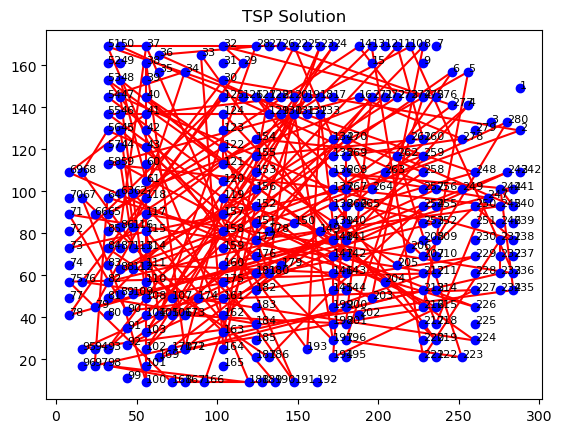

In [102]:
# 保存训练好的模型
model.save("ppo_tsp_model")

# 加载模型进行推理
loaded_model = PPO.load("ppo_tsp_model")

def visualize_tsp_solution(nodes, visited_order, title="TSP Solution"):
    fig, ax = plt.subplots()
    plt.scatter(nodes[:, 0], nodes[:, 1], c="blue", zorder=1)
    
    for i, node in enumerate(nodes):
        ax.annotate(i + 1, (node[0], node[1]), fontsize=8, zorder=2)
        
    visited_nodes = nodes[visited_order]
    
    for i in range(len(visited_nodes) - 1):
        plt.plot([visited_nodes[i][0], visited_nodes[i+1][0]], [visited_nodes[i][1], visited_nodes[i+1][1]], c="red", zorder=0)
    plt.plot([visited_nodes[-1][0], visited_nodes[0][0]], [visited_nodes[-1][1], visited_nodes[0][1]], c="red", zorder=0)
    
    plt.title(title)
    plt.show()

# 推理解决方案
obs = env.reset()
done = False
visited_order = [env.current_node - 1]

while not done:
    action, _ = loaded_model.predict(obs)
    obs, reward, done, info = env.step(action)
    if env.current_node not in visited_order:
        visited_order.append(env.current_node - 1)

# 可视化解决方案
nodes = np.array([env.problem.node_coords[node] for node in env.nodes])
visualize_tsp_solution(nodes, visited_order)


In [12]:
import os

def train_and_inference(env, model, n_episodes=10, total_timesteps=1000, save_path="results", save_img=True):
    os.makedirs(save_path, exist_ok=True)
    
    rewards = []  # 存储每个episode的reward
    for i in range(n_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0  # 当前episode的总reward

        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_reward += reward  # 累加当前步的reward

        rewards.append(episode_reward)  # 将当前episode的总reward存储到列表中
        print(f"Episode {i}: reward = {episode_reward}, length = {len(env.visited_order)}")
        model.learn(total_timesteps=total_timesteps)

    env.close()

    # 绘制reward随epoch变化的折线图
    plt.plot(range(n_episodes), rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    if save_img:
        plt.savefig(os.path.join(save_path, "reward_plot.png"))
    plt.show()

    # 保存训练好的模型
    model.save(os.path.join(save_path, "ppo_tsp_model"))

    # 加载模型进行推理
    loaded_model = PPO.load(os.path.join(save_path, "ppo_tsp_model"))

    # 推理解决方案
    obs = env.reset()
    done = False
    visited_order = [env.current_node - 1]

    while not done:
        action, _ = loaded_model.predict(obs)
        obs, reward, done, info = env.step(action)
        if env.current_node not in visited_order:
            visited_order.append(env.current_node - 1)

    # 可视化解决方案
    nodes = np.array([env.problem.node_coords[node] for node in env.nodes])
    visualize_tsp_solution(nodes, visited_order, save_path=save_path, save_img=save_img)

def visualize_tsp_solution(nodes, visited_order, title="TSP Solution", save_path="results", save_img=True):
    fig, ax = plt.subplots()
    plt.scatter(nodes[:, 0], nodes[:, 1], c="blue", zorder=1)
    
    for i, node in enumerate(nodes):
        ax.annotate(i + 1, (node[0], node[1]), fontsize=8, zorder=2)
        
    visited_nodes = nodes[visited_order]
    
    for i in range(len(visited_nodes) - 1):
        plt.plot([visited_nodes[i][0], visited_nodes[i+1][0]], [visited_nodes[i][1], visited_nodes[i+1][1]], c="red", zorder=0)
    plt.plot([visited_nodes[-1][0], visited_nodes[0][0]], [visited_nodes[-1][1], visited_nodes[0][1]], c="red", zorder=0)
    
    plt.title(title)
    if save_img:
        plt.savefig(os.path.join(save_path, "tsp_solution.png"))
    plt.show()



In [31]:

problem_file = 'tsp/a280.tsp'


n_episodes = 100
total_timesteps = 1000
save_img = True

algorithms = [ 'A2C']

for algorithm in algorithms:
    env = TSPEnv(problem_file=problem_file)
    print(f"Training with {algorithm} algorithm")
    if algorithm == 'PPO':
        model = PPO('MlpPolicy', env, verbose=1,batch_size=64)
    elif algorithm == 'DQN':
        model = DQN('MlpPolicy', env, verbose=1,batch_size=64)
    elif algorithm == 'A2C':
        model = A2C('MlpPolicy', env, verbose=1)
    
    save_path = f"results/{algorithm}"
    train_and_inference(env, model, n_episodes=n_episodes, total_timesteps=total_timesteps,
                        save_path=save_path, save_img=save_img)


280
Training with A2C algorithm
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 0: reward = -13339411, length = 279
-------------------------------------
| time/                 |           |
|    fps                | 224       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -5.6      |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -1.73e+05 |
|    value_loss         | 1.07e+09  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 683       |
|    ep_rew_mean        | -4.11e+06 |
| time/                 |           |
|    fps                | 222       |
|    iterations         | 200       |
|    time_elapsed       | 4    

KeyboardInterrupt: 

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ComplexQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ComplexQNetwork, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, output_dim)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        
        return x

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, input_dim, output_dim, q_network_class, hidden_dim=64, buffer_size=10000,
                 batch_size=64, gamma=0.99, learning_rate=1e-4,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):

        self.q_network = q_network_class(input_dim, output_dim)
        self.target_network = q_network_class(input_dim, output_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.visited_nodes = set()

    def reset_visited_nodes(self):
        self.visited_nodes = set()

    def predict(self, observation, deterministic=False):
        observation = observation.flatten()
        observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
        q_values = self.q_network(observation).detach().numpy().flatten()
        # print(q_values.shape)
        
        # Mask already visited nodes with -np.inf
        for visited_node in self.visited_nodes:
            q_values[visited_node] =1e-6 

        # action = np.argmax(q_values)
        if deterministic or np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.choice([x for x in range(len(q_values)) if x not in self.visited_nodes])

        return action

    def update(self, state, action, reward, next_state, done):
        self.buffer.add((state, action, reward, next_state, done))

        if len(self.buffer) >= self.batch_size:
            experiences = self.buffer.sample(self.batch_size)
            
            # Extract the values from the experiences
            states, actions, rewards, next_states, dones = zip(*experiences)
            
            # Flatten the states and next_states
            states = np.array(states).reshape(-1, 2 * self.q_network.fc1.in_features // 2)
            next_states = np.array(next_states).reshape(-1, 2 * self.q_network.fc1.in_features // 2)

            states = torch.tensor(states, dtype=torch.float32)
            actions = torch.tensor(actions, dtype=torch.long).unsqueeze(-1)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
            next_states = torch.tensor(next_states, dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.bool).unsqueeze(-1)


            q_values = self.q_network(states).gather(1, actions)
            next_q_values = self.target_network(next_states).max(1, keepdim=True)[0].detach()
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)

            loss = nn.MSELoss()(q_values, target_q_values)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update epsilon
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, filepath):
        torch.save(self.q_network.state_dict(), filepath)

    def load(self, filepath):
        self.q_network.load_state_dict(torch.load(filepath))

In [15]:

problem_file = 'tsp/att48.tsp'


save_img = True
env = TSPEnv(problem_file=problem_file)



n_cities = env.n_cities
n_episodes = 1000
update_target_every = 10

agent = DQNAgent(input_dim=2 * n_cities, output_dim=n_cities, q_network_class=ComplexQNetwork)


In [16]:
import matplotlib.pyplot as plt
import os

def train_and_inference_dqn(env, agent, n_episodes=100, update_target_every=10, save_path="results", save_img=True):
    os.makedirs(save_path, exist_ok=True)
    
    rewards = []  # 存储每个episode的reward
    for episode in range(n_episodes):
        agent.reset_visited_nodes()
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.predict(state)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state, done)
            agent.visited_nodes.add(action)
            state = next_state
            episode_reward += reward

        if episode % update_target_every == 0:
            agent.update_target_network()

        rewards.append(episode_reward)  # 将当前episode的总reward存储到列表中
        print(f"Episode {episode}: reward = {episode_reward}, length = {len(agent.visited_nodes)}")

    # 绘制reward随episode变化的折线图
    plt.plot(range(n_episodes), rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    if save_img:
        plt.savefig(os.path.join(save_path, "reward_plot.png"))
    plt.show()

    # 保存训练好的模型
    agent.save(os.path.join(save_path, "dqn_tsp_model.pt"))

    # 加载模型进行推理
    loaded_agent =  DQNAgent(input_dim=2 * n_cities, output_dim=n_cities, q_network_class=ComplexQNetwork)
    loaded_agent.load(os.path.join(save_path, "dqn_tsp_model.pt"))

    # 推理解决方案
    state = env.reset()
    done = False
    visited_order = []

    while not done:
        action = loaded_agent.predict(state, deterministic=True)
        state, reward, done, _ = env.step(action)
        if action not in visited_order:
            visited_order.append(action)

    # 可视化解决方案
    nodes = np.array([env.problem.node_coords[node] for node in env.nodes])
    visualize_tsp_solution(nodes, visited_order, save_path=save_path, save_img=save_img)

train_and_inference_dqn(env, agent, n_episodes=100, save_path="results", save_img=True)


AttributeError: 'int' object has no attribute 'flatten'

33 []
5 [33]
17 [33, 5]
21 [33, 5, 17]
40 [33, 5, 17, 21]
46 [33, 5, 17, 21, 40]
11 [33, 5, 17, 21, 40, 46]
24 [33, 5, 17, 21, 40, 46, 11]
26 [33, 5, 17, 21, 40, 46, 11, 24]
45 [33, 5, 17, 21, 40, 46, 11, 24, 26]
15 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45]
20 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45, 15]
10 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45, 15, 20]
14 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45, 15, 20, 10]
43 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45, 15, 20, 10, 14]
12 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45, 15, 20, 10, 14, 43]
8 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45, 15, 20, 10, 14, 43, 12]
0 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45, 15, 20, 10, 14, 43, 12, 8]
47 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45, 15, 20, 10, 14, 43, 12, 8, 0]
22 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45, 15, 20, 10, 14, 43, 12, 8, 0, 47]
32 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45, 15, 20, 10, 14, 43, 12, 8, 0, 47, 22]
36 [33, 5, 17, 21, 40, 46, 11, 24, 26, 45, 15, 20, 10, 14, 43, 12, 8, 0, 47, 22, 32]
27 [33, 5, 17, 21,

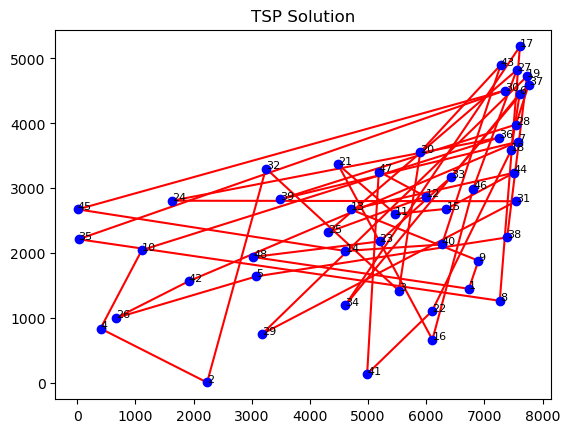

In [112]:
# 加载模型进行推理
loaded_agent =  DQNAgent(input_dim=2 * n_cities, output_dim=n_cities, q_network_class=ComplexQNetwork)
loaded_agent.load(os.path.join(save_path, "dqn_tsp_model.pt"))

# 推理解决方案
state = env.reset()
done = False
visited_order = []

while not done:
    action = loaded_agent.predict(state, deterministic=True)
    state, reward, done, _ = env.step(action)
    
    print(action,visited_order)
    if action not in visited_order:
        loaded_agent.visited_nodes.add(action)
        visited_order.append(action)

# 可视化解决方案
nodes = np.array([env.problem.node_coords[node] for node in env.nodes])
visualize_tsp_solution(nodes, visited_order, save_path=save_path, save_img=save_img)

In [65]:
save_path='results'